In [4]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Training data
app_train = pd.read_csv('dataset/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## DATASET APPLICATION

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [7]:
from sklearn.impute import SimpleImputer

col_num = list(app_train.select_dtypes('float64').columns)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
app_train[col_num] = imp_mean.fit_transform(app_train[col_num])

In [8]:
col_num = list(app_train.select_dtypes('int64').columns)
imp_meanN = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
app_train[col_num] = imp_meanN.fit_transform(app_train[col_num])

In [9]:

col_obj = list(app_train.select_dtypes('object').columns)
imp_cons = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NonRenseigne')
app_train[col_obj] = imp_cons.fit_transform(app_train[col_obj])

## Label Encoding et One Hot Encoding

In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    106
object      16
dtype: int64

In [11]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            app_train[col] = le.fit_transform(app_train[col])
            print('transformation colonne label encoding %s.' % col)            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

transformation colonne label encoding NAME_CONTRACT_TYPE.
transformation colonne label encoding FLAG_OWN_CAR.
transformation colonne label encoding FLAG_OWN_REALTY.
3 columns were label encoded.


In [12]:
# one-hot encoding of categorical variables
print('Training Features shape avant : ', app_train.shape)

app_train = pd.get_dummies(app_train)

print('Training Features shape apres : ', app_train.shape)

Training Features shape avant :  (307511, 122)
Training Features shape apres :  (307511, 249)


In [13]:
# Number of each type of column
app_train.dtypes.value_counts()

uint8      140
float64    106
int32        3
dtype: int64

## retour analyse EDA

In [14]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = ( app_train["DAYS_EMPLOYED"] == 365243 ).map(int)

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

app_train['DAYS_EMPLOYED_ANOM'].value_counts()

0    252137
1     55374
Name: DAYS_EMPLOYED_ANOM, dtype: int64

## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income | ratio total emprunt revenu
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income | taux endetemment
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [15]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [16]:
app_train[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'CREDIT_INCOME_PERCENT',
           'AMT_ANNUITY','AMT_INCOME_TOTAL', 'ANNUITY_INCOME_PERCENT',
           'AMT_ANNUITY', 'AMT_CREDIT','CREDIT_TERM',
           'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_EMPLOYED_PERCENT' ]]

,AMT_CREDIT,AMT_INCOME_TOTAL,CREDIT_INCOME_PERCENT,AMT_ANNUITY,AMT_INCOME_TOTAL,ANNUITY_INCOME_PERCENT,AMT_ANNUITY,AMT_CREDIT,CREDIT_TERM,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_EMPLOYED_PERCENT
0,406597.5,202500.0,2.007889,24700.5,202500.0,0.121978,24700.5,406597.5,0.060749,-637.0,-9461.0,0.067329
1,1293502.5,270000.0,4.790750,35698.5,270000.0,0.132217,35698.5,1293502.5,0.027598,-1188.0,-16765.0,0.070862
2,135000.0,67500.0,2.000000,6750.0,67500.0,0.100000,6750.0,135000.0,0.050000,-225.0,-19046.0,0.011814
3,312682.5,135000.0,2.316167,29686.5,135000.0,0.219900,29686.5,312682.5,0.094941,-3039.0,-19005.0,0.159905
4,513000.0,121500.0,4.222222,21865.5,121500.0,0.179963,21865.5,513000.0,0.042623,-3038.0,-19932.0,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,254700.0,157500.0,1.617143,27558.0,157500.0,0.174971,27558.0,254700.0,0.108198,-236.0,-9327.0,0.025303
307507,269550.0,72000.0,3.743750,12001.5,72000.0,0.166687,12001.5,269550.0,0.044524,0.0,-20775.0,-0.000000
307508,677664.0,153000.0,4.429176,29979.0,153000.0,0.195941,29979.0,677664.0,0.044239,-7921.0,-14966.0,0.529266
307509,370107.0,171000.0,2.164368,20205.0,171000.0,0.118158,20205.0,370107.0,0.054592,-4786.0,-11961.0,0.400134


# Ajout des donnees exterieures

In [17]:
# Read in bureau
bureau = pd.read_csv('dataset/bureau.csv')


In [18]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [19]:
# Join to the training dataframe
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_NonRenseigne,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,previous_loan_counts
0,100002.0,1.0,0,0,1,0.0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,0,0,2.007889,0.121978,0.060749,0.067329,8.0
1,100003.0,0.0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,4.790750,0.132217,0.027598,0.070862,4.0
2,100004.0,0.0,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,...,0,0,1,0,0,2.000000,0.100000,0.050000,0.011814,2.0
3,100006.0,0.0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,...,0,0,1,0,0,2.316167,0.219900,0.094941,0.159905,0.0
4,100007.0,0.0,0,0,1,0.0,121500.0,513000.0,21865.5,513000.0,...,0,0,1,0,0,4.222222,0.179963,0.042623,0.152418,1.0


In [17]:
app_train.isna().sum()

SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
                         ..
CREDIT_INCOME_PERCENT     0
ANNUITY_INCOME_PERCENT    0
CREDIT_TERM               0
DAYS_EMPLOYED_PERCENT     0
previous_loan_counts      0
Length: 255, dtype: int64

In [18]:
from sklearn.decomposition import PCA

pca_affich = PCA(n_components=2)
feat_pca_affich= pca_affich.fit_transform(app_train)

In [21]:
feat_pca_affich[:,1]

array([ 56392.1839935 ,  23971.172714  , -48864.49123061, ...,
       -23526.77505115,  28718.88228821, -23719.75171691])

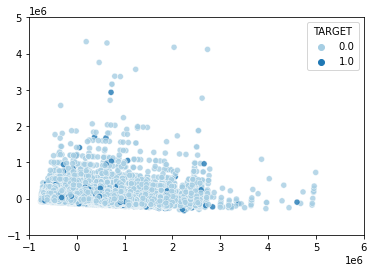

In [26]:
sns.scatterplot(
    x=feat_pca_affich[:,0], y=feat_pca_affich[:,1], hue = app_train.TARGET, legend="brief", alpha=0.8, palette='Paired')
plt.xlim(-1e6,0.6e7)
plt.ylim(-1e6,0.5e7)
plt.show()

# BASELINE

In [20]:
import re
from collections import Counter

app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = app_train.drop(columns='TARGET').copy()
y = app_train['TARGET'].copy()


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1944)

In [22]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0.0: 226148, 1.0: 19860})
y_val Counter({0.0: 56538, 1.0: 4965})


### definition metrique et fonction evaluation

In [23]:
# il est important de faire ressortir les FNs car perte de capital
# trouver les TP est interessant aussi car interet
# les FP sont moins risqués car perte d'interet seulement
def custom_metric(y, y_pred):
    TP = np.sum( (y==1) & (y_pred==1) )
    FP = np.sum( (y==0) & (y_pred==1) )
    TN = np.sum( (y==0) & (y_pred==0) )
    FN = np.sum( (y==1) & (y_pred==0) )
# Fowlkes–Mallows index 
# https://en.wikipedia.org/wiki/Confusion_matrix
# https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index
# Positive predictive value PPV
    PPV = TP / (TP + FP)
# Positive predictive value TPR
    TPR = TP / (TP + FN)
    FMI = np.sqrt( PPV * TPR )
    return FMI

In [24]:
from sklearn.metrics import make_scorer

custom_scorer = make_scorer(custom_metric, greater_is_better=True )

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(conf_mat)
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()
#    print(classification_report(yval, yval_pred))

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



## Logistic regression

[[56538     0]
 [ 4965     0]]
Accuracy score    : 0.919
precision score   : 0.0
recall score      : 0.0
F1 score          : 0.0
ROCAUC score      : 0.5
custom metric FMI : nan



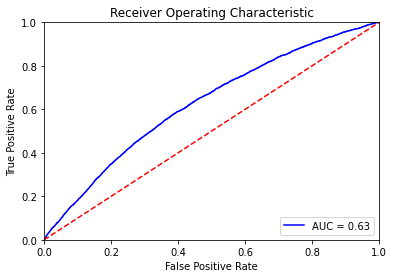

In [26]:
from sklearn.linear_model import LogisticRegression

logis = LogisticRegression(solver='liblinear')
logis.fit(X_train, y_train)

model_eval(logis, X_val, y_val)

## gestion desequilibre
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

### gestion desequilibre
essai sous echantillonage

In [81]:
from imblearn.under_sampling import RandomUnderSampler

sample = RandomUnderSampler(random_state=1944)

# fit and apply the transform
X_under, y_under = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_under))


Counter({0.0: 226148, 1.0: 19860})
Counter({0.0: 19860, 1.0: 19860})


[[35285 21253]
 [ 2324  2641]]
Accuracy score    : 0.617
precision score   : 0.111
recall score      : 0.532
F1 score          : 0.183
ROCAUC score      : 0.578
custom metric FMI : 0.242

              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75     56538
         1.0       0.11      0.53      0.18      4965

    accuracy                           0.62     61503
   macro avg       0.52      0.58      0.47     61503
weighted avg       0.87      0.62      0.70     61503



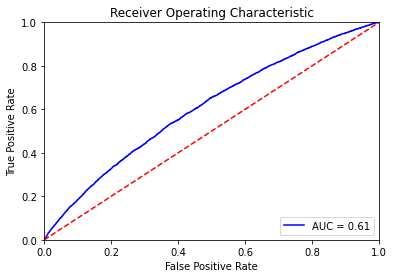

In [100]:
logis_under = LogisticRegression(solver='liblinear')
logis_under.fit(X_under, y_under)

model_eval(logis_under, X_val, y_val)

In [82]:
from imblearn.under_sampling import NearMiss


sample_undermiss = NearMiss()

# fit and apply the transform
X_undermis, y_undermiss = sample_undermiss.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_undermiss))


Counter({0.0: 226148, 1.0: 19860})
Counter({0.0: 19860, 1.0: 19860})


[[24791 31747]
 [ 1740  3225]]
Accuracy score    : 0.456
precision score   : 0.0922
recall score      : 0.65
F1 score          : 0.162
ROCAUC score      : 0.544
custom metric FMI : 0.245

              precision    recall  f1-score   support

         0.0       0.93      0.44      0.60     56538
         1.0       0.09      0.65      0.16      4965

    accuracy                           0.46     61503
   macro avg       0.51      0.54      0.38     61503
weighted avg       0.87      0.46      0.56     61503



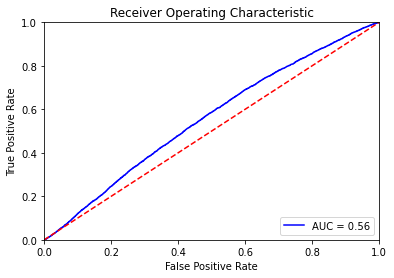

In [111]:
logis_undermiss = LogisticRegression(solver='liblinear')
logis_undermiss.fit(X_undermis, y_undermiss)

model_eval(logis_undermiss, X_val, y_val)

### gestion desequilibre
essai surechantillonage

In [83]:
from imblearn.over_sampling import SMOTE

sample = SMOTE(sampling_strategy=0.5, random_state=1944)

# fit and apply the transform
X_over, y_over = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_over))


Counter({0.0: 226148, 1.0: 19860})
Counter({0.0: 226148, 1.0: 113074})


[[55414  1124]
 [ 4702   263]]
Accuracy score    : 0.905
precision score   : 0.19
recall score      : 0.053
F1 score          : 0.0828
ROCAUC score      : 0.517
custom metric FMI : 0.1

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     56538
         1.0       0.19      0.05      0.08      4965

    accuracy                           0.91     61503
   macro avg       0.56      0.52      0.52     61503
weighted avg       0.86      0.91      0.88     61503



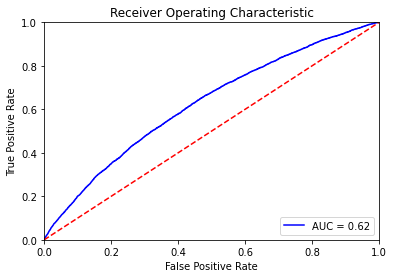

In [103]:
logis_over = LogisticRegression(solver='liblinear')
logis_over.fit(X_over, y_over)

model_eval(logis_over, X_val, y_val)

### gestion desequilibre
essai melange sous-echantillonage et surechantillonage

In [84]:
from imblearn.combine import SMOTEENN

sample = SMOTEENN(random_state=1944)

# fit and apply the transform
X_smote, y_smote = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_smote))


Counter({0.0: 226148, 1.0: 19860})
Counter({1.0: 207302, 0.0: 139787})


[[16729 39809]
 [  945  4020]]
Accuracy score    : 0.337
precision score   : 0.0917
recall score      : 0.81
F1 score          : 0.165
ROCAUC score      : 0.553
custom metric FMI : 0.273

              precision    recall  f1-score   support

         0.0       0.95      0.30      0.45     56538
         1.0       0.09      0.81      0.16      4965

    accuracy                           0.34     61503
   macro avg       0.52      0.55      0.31     61503
weighted avg       0.88      0.34      0.43     61503



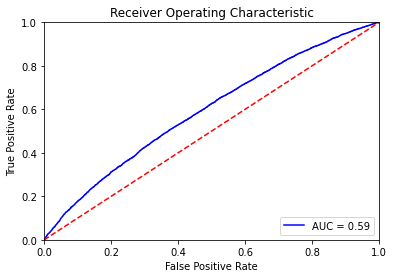

In [107]:
logis_smoteenn = LogisticRegression(solver='liblinear')
logis_smoteenn.fit(X_smote, y_smote)

model_eval(logis_smoteenn, X_val, y_val)

## Dectision Tree

[[51697  4841]
 [ 4150   815]]
Accuracy score    : 0.854
precision score   : 0.144
recall score      : 0.164
F1 score          : 0.153
ROCAUC score      : 0.539
custom metric FMI : 0.154

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     56538
         1.0       0.14      0.16      0.15      4965

    accuracy                           0.85     61503
   macro avg       0.53      0.54      0.54     61503
weighted avg       0.86      0.85      0.86     61503



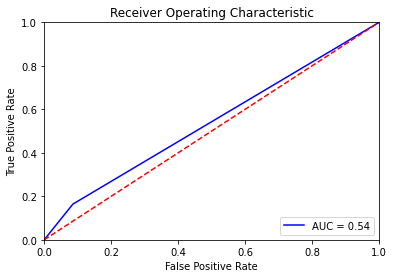

In [91]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier(random_state=1944)
dectree.fit(X_train, y_train)
model_eval(dectree, X_val, y_val)

In [112]:
from imblearn.over_sampling import SMOTE

sample_under = RandomUnderSampler(random_state=1944)
sample_over = SMOTE(sampling_strategy=0.5, random_state=1944)
sample_undermiss = NearMiss()
sample = SMOTEENN(random_state=1944)


# fit and apply the transform
X_under, y_under = sample_under.fit_resample(X_train, y_train)
X_undermis, y_undermiss = sample_undermiss.fit_resample(X_train, y_train)
X_over, y_over = sample_over.fit_resample(X_train, y_train)
X_smote, y_smote = sample.fit_resample(X_train, y_train)

In [113]:
dectree_under = DecisionTreeClassifier(random_state=1944)
dectree_undermiss = DecisionTreeClassifier(random_state=1944)
dectree_over = DecisionTreeClassifier(random_state=1944)
dectree_smoteenn = DecisionTreeClassifier(random_state=1944)

dectree_under.fit(X_under, y_under)
dectree_undermiss.fit(X_undermis, y_undermiss)
dectree_over.fit(X_over, y_over)
dectree_smoteenn.fit(X_smote, y_smote)


DecisionTreeClassifier(random_state=1944)

[[33226 23312]
 [ 2052  2913]]
Accuracy score    : 0.588
precision score   : 0.111
recall score      : 0.587
F1 score          : 0.187
ROCAUC score      : 0.587
custom metric FMI : 0.255

              precision    recall  f1-score   support

         0.0       0.94      0.59      0.72     56538
         1.0       0.11      0.59      0.19      4965

    accuracy                           0.59     61503
   macro avg       0.53      0.59      0.46     61503
weighted avg       0.87      0.59      0.68     61503



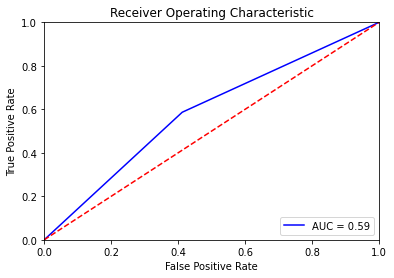

In [114]:
model_eval(dectree_under, X_val, y_val)

[[15496 41042]
 [ 1171  3794]]
Accuracy score    : 0.314
precision score   : 0.0846
recall score      : 0.764
F1 score          : 0.152
ROCAUC score      : 0.519
custom metric FMI : 0.254

              precision    recall  f1-score   support

         0.0       0.93      0.27      0.42     56538
         1.0       0.08      0.76      0.15      4965

    accuracy                           0.31     61503
   macro avg       0.51      0.52      0.29     61503
weighted avg       0.86      0.31      0.40     61503



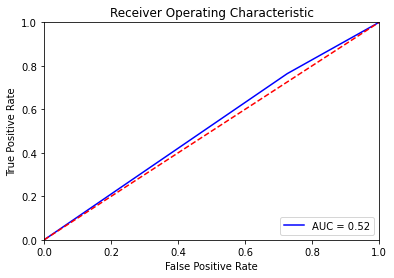

In [115]:
model_eval(dectree_undermiss, X_val, y_val)

[[51255  5283]
 [ 4105   860]]
Accuracy score    : 0.847
precision score   : 0.14
recall score      : 0.173
F1 score          : 0.155
ROCAUC score      : 0.54
custom metric FMI : 0.156

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     56538
         1.0       0.14      0.17      0.15      4965

    accuracy                           0.85     61503
   macro avg       0.53      0.54      0.54     61503
weighted avg       0.86      0.85      0.85     61503



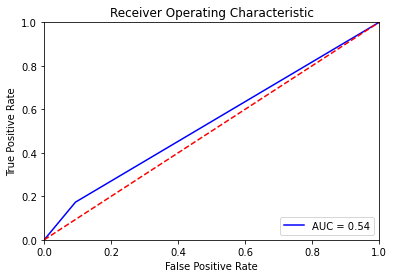

In [116]:
model_eval(dectree_over, X_val, y_val)

[[48994  7544]
 [ 3831  1134]]
Accuracy score    : 0.815
precision score   : 0.131
recall score      : 0.228
F1 score          : 0.166
ROCAUC score      : 0.547
custom metric FMI : 0.173

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     56538
         1.0       0.13      0.23      0.17      4965

    accuracy                           0.82     61503
   macro avg       0.53      0.55      0.53     61503
weighted avg       0.86      0.82      0.84     61503



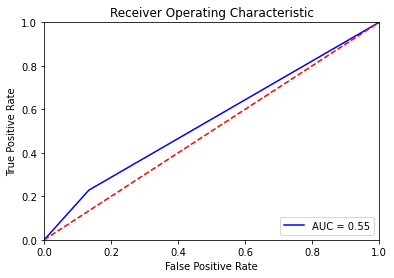

In [117]:
model_eval(dectree_smoteenn, X_val, y_val)

## RandomForest

[[56538     0]
 [ 4965     0]]
Accuracy score    : 0.919
precision score   : 0.0
recall score      : 0.0
F1 score          : 0.0
ROCAUC score      : 0.5
custom metric FMI : nan



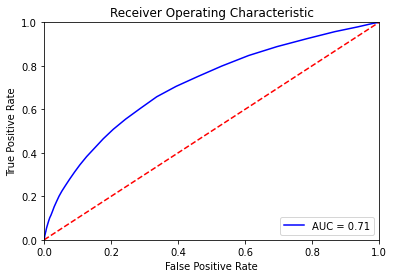

In [27]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(random_state=1944)

randomForest.fit(X_train, y_train)
model_eval(randomForest, X_val, y_val)

[[56519    19]
 [ 4943    22]]
Accuracy score    : 0.919
precision score   : 0.537
recall score      : 0.00443
F1 score          : 0.00879
ROCAUC score      : 0.502
custom metric FMI : 0.0488



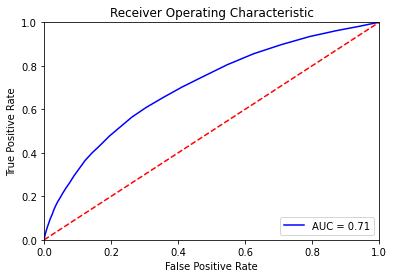

In [46]:
randomForest_weight = RandomForestClassifier(random_state=1944, class_weight={0:10,1:1})

randomForest_weight.fit(X_train, y_train)
model_eval(randomForest_weight, X_val, y_val)

In [85]:
randomForest_under = RandomForestClassifier(random_state=1944)
randomForest_undermiss = RandomForestClassifier(random_state=1944)
randomForest_over = RandomForestClassifier(random_state=1944)
randomForest_smoteenn = RandomForestClassifier(random_state=1944)

randomForest_under.fit(X_under, y_under)
randomForest_undermiss.fit(X_undermis, y_undermiss)
randomForest_over.fit(X_over, y_over)
randomForest_smoteenn.fit(X_smote, y_smote)


RandomForestClassifier(random_state=1944)

[[39506 17032]
 [ 1763  3202]]
Accuracy score    : 0.694
precision score   : 0.158
recall score      : 0.645
F1 score          : 0.254
ROCAUC score      : 0.672
custom metric FMI : 0.319

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56538
         1.0       0.16      0.64      0.25      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.69      0.76     61503



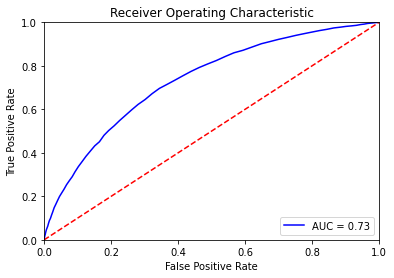

In [119]:
model_eval(randomForest_under, X_val, y_val)

[[16187 40351]
 [  991  3974]]
Accuracy score    : 0.328
precision score   : 0.0897
recall score      : 0.8
F1 score          : 0.161
ROCAUC score      : 0.543
custom metric FMI : 0.268

              precision    recall  f1-score   support

         0.0       0.94      0.29      0.44     56538
         1.0       0.09      0.80      0.16      4965

    accuracy                           0.33     61503
   macro avg       0.52      0.54      0.30     61503
weighted avg       0.87      0.33      0.42     61503



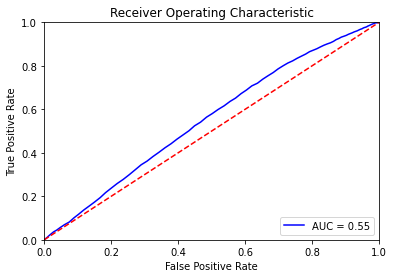

In [120]:
model_eval(randomForest_undermiss, X_val, y_val)

[[56538     0]
 [ 4963     2]]
Accuracy score    : 0.919
precision score   : 1.0
recall score      : 0.000403
F1 score          : 0.000805
ROCAUC score      : 0.5
custom metric FMI : 0.0201

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       1.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.93      0.92      0.88     61503



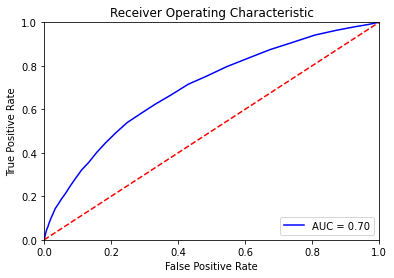

In [121]:
model_eval(randomForest_over, X_val, y_val)

[[56464    74]
 [ 4911    54]]
Accuracy score    : 0.919
precision score   : 0.422
recall score      : 0.0109
F1 score          : 0.0212
ROCAUC score      : 0.505
custom metric FMI : 0.0677

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.42      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.67      0.50      0.49     61503
weighted avg       0.88      0.92      0.88     61503



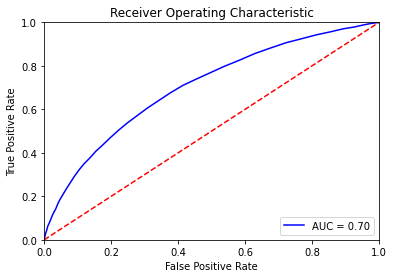

In [122]:
model_eval(randomForest_smoteenn, X_val, y_val)

### a priori RandomForest avec strategie d'underFitting semble la plus prometteuse

In [43]:
model_eval_score(logis_under, X_val, y_val)

NameError: name 'logis_under' is not defined

In [125]:
model_eval_score(dectree_under, X_val, y_val)

[[33226 23312]
 [ 2052  2913]]
Accuracy score    : 0.588
precision score   : 0.111
recall score      : 0.587
F1 score          : 0.187
ROCAUC score      : 0.587
custom metric FMI : 0.255



In [44]:
model_eval_score(randomForest_under, X_val, y_val)

NameError: name 'randomForest_under' is not defined

In [28]:
from xgboost import XGBClassifier

model10 = XGBClassifier(scale_pos_weight=10)
model = XGBClassifier()

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
model10.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

[0]	validation_0-auc:0.72010	validation_1-auc:0.70957
[99]	validation_0-auc:0.86019	validation_1-auc:0.75848
[0]	validation_0-auc:0.72479	validation_1-auc:0.71052
[99]	validation_0-auc:0.86545	validation_1-auc:0.75390


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[56371   167]
 [ 4819   146]]
Accuracy score    : 0.919
precision score   : 0.466
recall score      : 0.0294
F1 score          : 0.0553
ROCAUC score      : 0.513
custom metric FMI : 0.117

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.47      0.03      0.06      4965

    accuracy                           0.92     61503
   macro avg       0.69      0.51      0.51     61503
weighted avg       0.88      0.92      0.88     61503



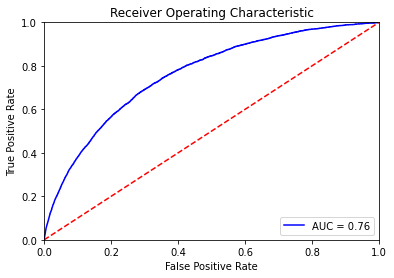

In [93]:
model_eval(model, X_val, y_val)

[[43332 13206]
 [ 1932  3033]]
Accuracy score    : 0.754
precision score   : 0.187
recall score      : 0.611
F1 score          : 0.286
ROCAUC score      : 0.689
custom metric FMI : 0.338



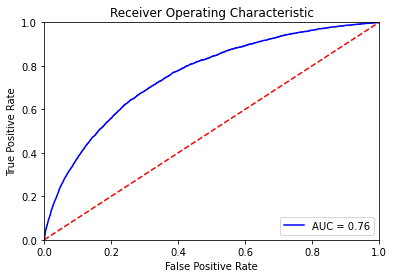

In [29]:
model_eval(model10, X_val, y_val)

In [64]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid
random_grid = {
               'n_estimators' : range(50, 200, 500),
               'learning_rate': [0.01,0.05,0.1,0.3,1],
               'max_depth' : [2, 3, 5],
               'colsample_bytree': [0.8, 0.9, 1.0],
                'subsample': [0.8, 0.9, 1.0],
                'min_child_weight' : [1, 2, 3],
                'reg_lambda': [1.1, 1.2, 1.3]
              }

                    
print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = XGBClassifier(scale_pos_weight=10, eval_metric='logloss'), scoring=custom_scorer, param_distributions = random_grid, n_iter = 70, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

{'n_estimators': range(50, 200, 500), 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'max_depth': [2, 3, 5], 'colsample_bytree': [0.8, 0.9, 1.0], 'subsample': [0.8, 0.9, 1.0], 'min_child_weight': [1, 2, 3], 'reg_lambda': [1.1, 1.2, 1.3]}
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 39.8min finished


{'subsample': 1.0, 'reg_lambda': 1.3, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}


[[41866 14672]
 [ 1817  3148]]
Accuracy score    : 0.732
precision score   : 0.177
recall score      : 0.634
F1 score          : 0.276
ROCAUC score      : 0.687
custom metric FMI : 0.335



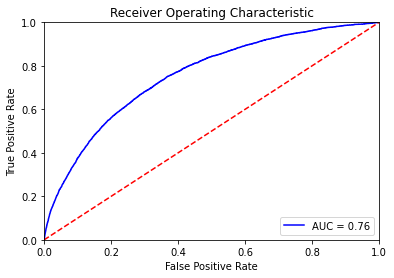

In [65]:
model_eval(rf_random.best_estimator_, X_val, y_val)

In [66]:
from sklearn.model_selection import GridSearchCV
import timeit

start_time = timeit.default_timer()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1944)

params_grid = {
               'n_estimators' : [50, 100],
               'learning_rate': [0.2, 0.3, 0.4],
               'max_depth' : [2, 3],
               'colsample_bytree': [0.8, 0.9],
                'subsample': [ 0.9, 1.0],
                'min_child_weight' : [2, 3],
                'reg_lambda': [1.3, 1.4]
              }

                    
print(params_grid)

grid = GridSearchCV( XGBClassifier(scale_pos_weight=10, eval_metric='logloss'),params_grid, cv=skf, scoring=custom_scorer, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)
#print(grid.cv_results_)

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')


{'n_estimators': [50, 100], 'learning_rate': [0.2, 0.3, 0.4], 'max_depth': [2, 3], 'colsample_bytree': [0.8, 0.9], 'subsample': [0.9, 1.0], 'min_child_weight': [2, 3], 'reg_lambda': [1.3, 1.4]}
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 67.2min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 121.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 199.8min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 245.3min finished


resultat en 14746.14s


In [67]:
grid.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.3,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 100,
 'reg_lambda': 1.4,
 'subsample': 1.0}

[[42229 14309]
 [ 1783  3182]]
Accuracy score    : 0.738
precision score   : 0.182
recall score      : 0.641
F1 score          : 0.283
ROCAUC score      : 0.694
custom metric FMI : 0.341



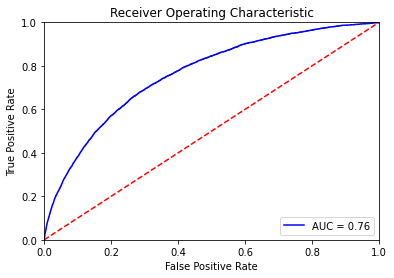

In [68]:
grid_xgb = grid.best_estimator_
model_eval(grid_xgb, X_val, y_val)

In [124]:
model_eval_score(randomForest_under, X_val, y_val)

[[39506 17032]
 [ 1763  3202]]
Accuracy score    : 0.694
precision score   : 0.158
recall score      : 0.645
F1 score          : 0.254
ROCAUC score      : 0.672
custom metric FMI : 0.319



In [30]:
model_eval_score(model10, X_val, y_val)

[[43332 13206]
 [ 1932  3033]]
Accuracy score    : 0.754
precision score   : 0.187
recall score      : 0.611
F1 score          : 0.286
ROCAUC score      : 0.689
custom metric FMI : 0.338



In [69]:
model_eval_score(grid_xgb, X_val, y_val)

[[42229 14309]
 [ 1783  3182]]
Accuracy score    : 0.738
precision score   : 0.182
recall score      : 0.641
F1 score          : 0.283
ROCAUC score      : 0.694
custom metric FMI : 0.341



In [90]:
import pickle

with open('randomForest_model.p', 'wb') as f1:
    pickle.dump(randomForest_under, f1)
    
with open('grid_xgb.p', 'wb') as f1:
    pickle.dump(grid_xgb, f1)

with open('app_train.p', 'wb') as f1:
    pickle.dump(app_train, f1)
    

In [91]:
df_total = pd.read_csv('df_total.csv')

In [92]:
df_total

,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INS_48M_SK_DPD_MAX,INS_48M_SK_DPD_SUM,INS_48M_DRAWING_LIMIT_RATIO_MIN,INS_48M_DRAWING_LIMIT_RATIO_MAX,INS_48M_LATE_PAYMENT_MEAN,INS_48M_LATE_PAYMENT_SUM,INS_48M_CARD_IS_DPD_UNDER_120_MEAN,INS_48M_CARD_IS_DPD_UNDER_120_SUM,INS_48M_CARD_IS_DPD_OVER_120_MEAN,INS_48M_CARD_IS_DPD_OVER_120_SUM
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,456251,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307502,307502,456252,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,307503,456253,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,307504,456254,1,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
df_total.drop(columns='Unnamed: 0', inplace=True)

In [96]:
import re
from collections import Counter

df_total = df_total.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df_total.drop(columns='TARGET').copy()
y = df_total['TARGET'].copy()


In [97]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1944)

In [98]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0: 226145, 1: 19859})
y_val Counter({0: 56537, 1: 4965})


In [99]:
from xgboost import XGBClassifier

model10_total = XGBClassifier(scale_pos_weight=10)

model10_total.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

[0]	validation_0-auc:0.74517	validation_1-auc:0.72673
[99]	validation_0-auc:0.91133	validation_1-auc:0.77116


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[44178 12359]
 [ 1864  3101]]
Accuracy score    : 0.769
precision score   : 0.201
recall score      : 0.625
F1 score          : 0.304
ROCAUC score      : 0.703
custom metric FMI : 0.354



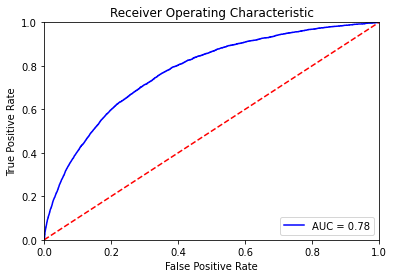

In [101]:
model_eval(model10_total, X_val, y_val)

In [102]:
df_feats = pd.read_csv('df_feats.csv')

In [103]:
df_feats

,Unnamed: 0,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,...,BURO_CREDIT_TYPE_Mortgage_MEAN,AMT_GOODS_PRICE,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_7,FLAG_DOCUMENT_18,NONLIVINGAPARTMENTS_MEDI,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,0,1,100002,0.0,NaN,1.00000,6.0,NaN,NaN,NaN,...,0.0,351000.0,24.00,0,0,0.0000,40.5000,0,9251.775,49156.20
1,1,0,100003,0.0,NaN,1.00000,1.0,NaN,NaN,NaN,...,0.0,1129500.0,10.00,0,0,0.0039,0.0000,0,6662.970,0.00
2,2,0,100004,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,135000.0,4.00,0,0,NaN,NaN,0,5357.250,0.00
3,3,0,100006,0.0,NaN,1.00000,3.0,0.0,NaN,0.0,...,NaN,297000.0,18.00,0,0,NaN,NaN,0,2482.920,NaN
4,4,0,100007,0.0,NaN,1.00000,14.0,NaN,NaN,NaN,...,0.0,513000.0,20.67,0,0,NaN,NaN,0,0.180,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0,456251,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,8.00,0,0,0.0757,NaN,0,6605.910,NaN
307502,307502,0,456252,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,6.00,0,0,0.0000,NaN,0,10046.880,NaN
307503,307503,0,456253,5.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,585000.0,5.00,0,0,0.0000,NaN,0,27.270,448958.25
307504,307504,1,456254,0.0,NaN,1.00000,12.0,NaN,NaN,NaN,...,0.0,319500.0,15.00,0,0,NaN,NaN,0,2296.440,0.00


In [105]:
df_feats.drop(columns='Unnamed: 0', inplace=True)

In [106]:
import re
from collections import Counter

df_feats = df_feats.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df_feats.drop(columns='TARGET').copy()
y = df_feats['TARGET'].copy()


In [107]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1944)

In [108]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0: 226145, 1: 19859})
y_val Counter({0: 56537, 1: 4965})


In [109]:
from xgboost import XGBClassifier

model10_feats = XGBClassifier(scale_pos_weight=10)

model10_feats.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

[0]	validation_0-auc:0.72845	validation_1-auc:0.71234
[99]	validation_0-auc:0.89189	validation_1-auc:0.77286


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[44097 12440]
 [ 1895  3070]]
Accuracy score    : 0.767
precision score   : 0.198
recall score      : 0.618
F1 score          : 0.3
ROCAUC score      : 0.699
custom metric FMI : 0.35



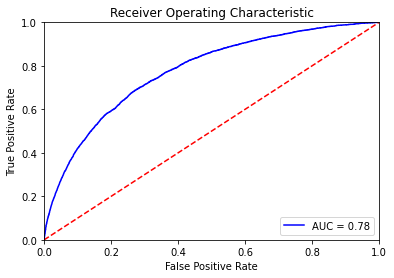

In [110]:
model_eval(model10_feats, X_val, y_val)

In [111]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid
random_grid = {
               'n_estimators' : range(50, 200, 500),
               'learning_rate': [0.01,0.05,0.1,0.3,1],
               'max_depth' : [2, 3, 5],
               'colsample_bytree': [0.8, 0.9, 1.0],
                'subsample': [0.8, 0.9, 1.0],
                'min_child_weight' : [1, 2, 3],
                'reg_lambda': [1.1, 1.2, 1.3]
              }

                    
print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_feats = RandomizedSearchCV(estimator = XGBClassifier(scale_pos_weight=10, eval_metric='logloss'), scoring=custom_scorer, param_distributions = random_grid, n_iter = 70, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
rf_random_feats.fit(X_train, y_train)

print(rf_random_feats.best_params_)

{'n_estimators': range(50, 200, 500), 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'max_depth': [2, 3, 5], 'colsample_bytree': [0.8, 0.9, 1.0], 'subsample': [0.8, 0.9, 1.0], 'min_child_weight': [1, 2, 3], 'reg_lambda': [1.1, 1.2, 1.3]}
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 53.7min finished


{'subsample': 0.8, 'reg_lambda': 1.3, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1.0}


[[42608 13929]
 [ 1731  3234]]
Accuracy score    : 0.745
precision score   : 0.188
recall score      : 0.651
F1 score          : 0.292
ROCAUC score      : 0.702
custom metric FMI : 0.35



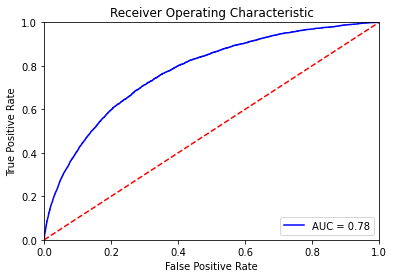

In [112]:
model_eval(rf_random_feats.best_estimator_, X_val, y_val)

In [114]:
start_time = timeit.default_timer()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1944)

params_grid = {
               'n_estimators' : [50, 100],
               'learning_rate': [0.2, 0.3, 0.4],
               'max_depth' : [3, 4],
               'colsample_bytree': [0.9, 1],
                'subsample': [ 0.8, 0.9],
                'min_child_weight' : [1, 2],
                'reg_lambda': [1.3, 1.4]
              }

                    
print(params_grid)

grid_feats = GridSearchCV( XGBClassifier(scale_pos_weight=10, eval_metric='logloss'),params_grid, cv=skf, scoring=custom_scorer, n_jobs=-1, verbose=3)
grid_feats.fit(X_train, y_train)
#print(grid.cv_results_)

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')


{'n_estimators': [50, 100], 'learning_rate': [0.2, 0.3, 0.4], 'max_depth': [3, 4], 'colsample_bytree': [0.9, 1], 'subsample': [0.8, 0.9], 'min_child_weight': [1, 2], 'reg_lambda': [1.3, 1.4]}
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.6min


KeyboardInterrupt: 

In [ ]:
grid_feats.best_params_

In [ ]:
grid_xgb_feats = grid_feats.best_estimator_
model_eval(grid_xgb_feats, X_val, y_val)

In [69]:
model_eval_score(grid_xgb, X_val, y_val)

[[42229 14309]
 [ 1783  3182]]
Accuracy score    : 0.738
precision score   : 0.182
recall score      : 0.641
F1 score          : 0.283
ROCAUC score      : 0.694
custom metric FMI : 0.341

